In [1]:
# load libraries
library(MatchIt)
library(dplyr)
library(ggplot2)
library(cobalt)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


 cobalt (Version 4.3.2, Build Date: 2022-01-19)


Attaching package: ‘cobalt’


The following object is masked from ‘package:MatchIt’:

    lalonde




In [ ]:
# read dataframe
data = read.csv("input/matching_data.csv")
rownames(data) = data$sub_id
head(data)

In [24]:
# remove subjects with missing values for matchit  
data_nomiss <- data %>%
    select(age, sex, years_of_education, hypertension, diabetes, hyperlipidemia, smoking_ever, cohort, tmt_a, tmt_b, word_list_recall,
    animal_naming_test, mini_mental_state) %>%
    na.omit()

In [25]:
dim(data_nomiss)

[1] 651  13

In [27]:
# Compute propensity scores by hand to plot
m_ps <- glm(cohort ~ age + sex + years_of_education + hypertension + hyperlipidemia + smoking_ever + diabetes, family=binomial(), data=data_nomiss)
ps_df <- data.frame(pr_score = predict(m_ps, type="response"), covid = m_ps$model$cohort)
print(head(ps_df))
labs <- paste("Postcovid", c("Yes", "No"))
graph <- ps_df %>%
  mutate(metabolic_syndrome = ifelse(covid == 1, labs[1], labs[2])) %>%
  ggplot(aes(x = pr_score)) +
  geom_histogram(color = "white") +
  facet_wrap(~covid) +
  xlab("Probability of having postcovid") +
  theme_bw()
  ggsave("../output/matching/propensity_scores.png")

              pr_score covid
sub-002144a4 0.4135643     0
sub-003db57e 0.4027200     1
sub-0171efa5 0.1593422     0
sub-018ad760 0.4972468     1
sub-026201f6 0.3435689     1
sub-0334dd14 0.5530803     1


Saving 6.67 x 6.67 in image

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [28]:
unmatched <- matchit(cohort ~ age + as.factor(sex) + years_of_education + as.factor(hypertension) + as.factor(hyperlipidemia) + as.factor(smoking_ever) + as.factor(diabetes),
    method=NULL, distance="glm", data=data_nomiss, replace=FALSE)

In [29]:
# Perform matching # 
mod_matchit <- matchit(cohort ~ age + as.factor(sex) + years_of_education + as.factor(hypertension) + as.factor(hyperlipidemia) + as.factor(smoking_ever) + as.factor(diabetes),
    method="optimal", distance="glm", data=data_nomiss, replace=FALSE)

In [30]:
# matchit object
mod_matchit

A matchit object
 - method: 1:1 optimal pair matching
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 651 (original), 446 (matched)
 - target estimand: ATT
 - covariates: age, as.factor(sex), years_of_education, as.factor(hypertension), as.factor(hyperlipidemia), as.factor(smoking_ever), as.factor(diabetes)

In [31]:
# Matching summary
matched_summary = summary(mod_matchit); print(matched_summary)


Call:
matchit(formula = cohort ~ age + as.factor(sex) + years_of_education + 
    as.factor(hypertension) + as.factor(hyperlipidemia) + as.factor(smoking_ever) + 
    as.factor(diabetes), data = data_nomiss, method = "optimal", 
    distance = "glm", replace = FALSE)

Summary of Balance for All Data:
                             Means Treated Means Control Std. Mean Diff.
distance                            0.3794        0.3233          0.4887
age                                55.5381       58.0187         -0.3506
`as.factor(sex)`0                   0.5516        0.5771         -0.0513
`as.factor(sex)`1                   0.4484        0.4229          0.0513
years_of_education                 15.6979       14.8353          0.3370
`as.factor(hypertension)`0          0.4126        0.3715          0.0834
`as.factor(hypertension)`1          0.5874        0.6285         -0.0834
`as.factor(hyperlipidemia)`0        0.7578        0.8154         -0.1344
`as.factor(hyperlipidemia)`1        0.24

Saving 6.67 x 6.67 in image



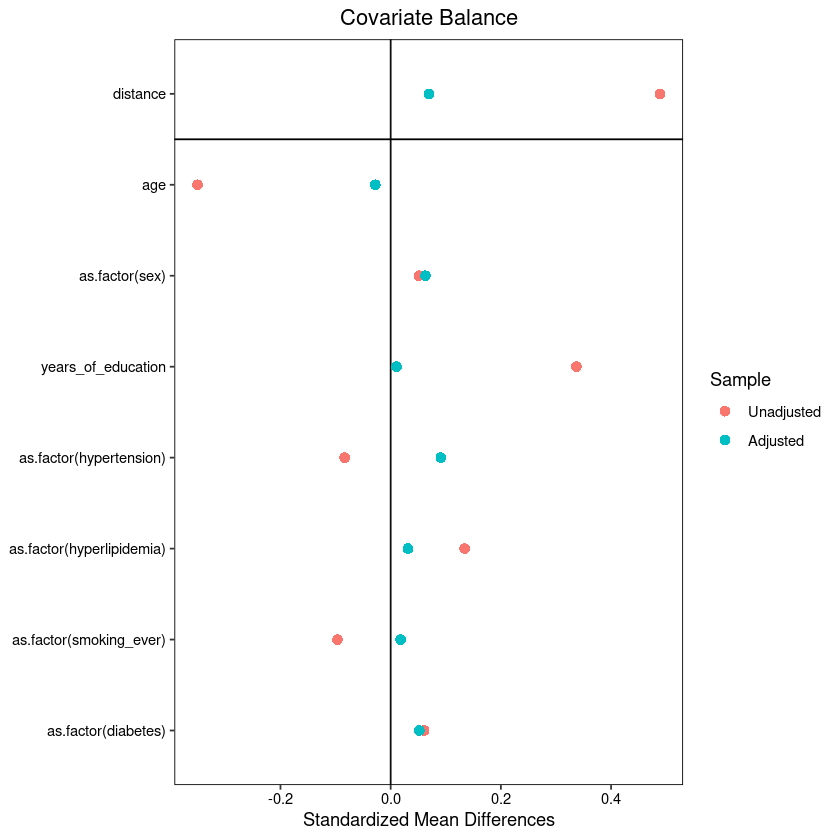

In [32]:
# Create love plot for balance assessment
love.plot(mod_matchit, binary="std")
ggsave("../output/matching/loveplot_matching.png")

Saving 6.67 x 6.67 in image



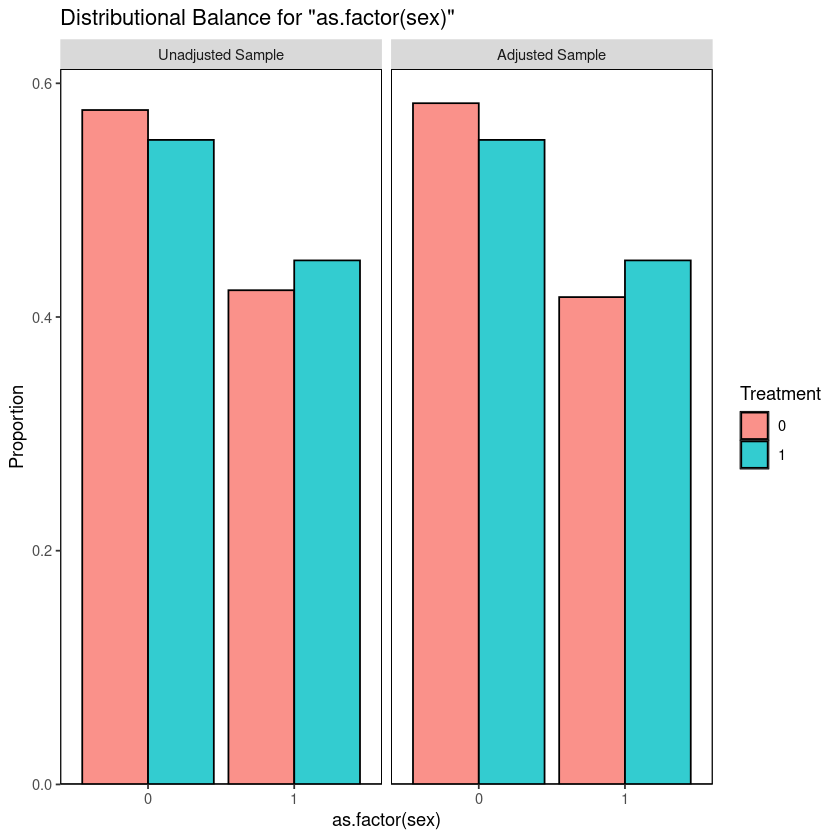

Saving 6.67 x 6.67 in image



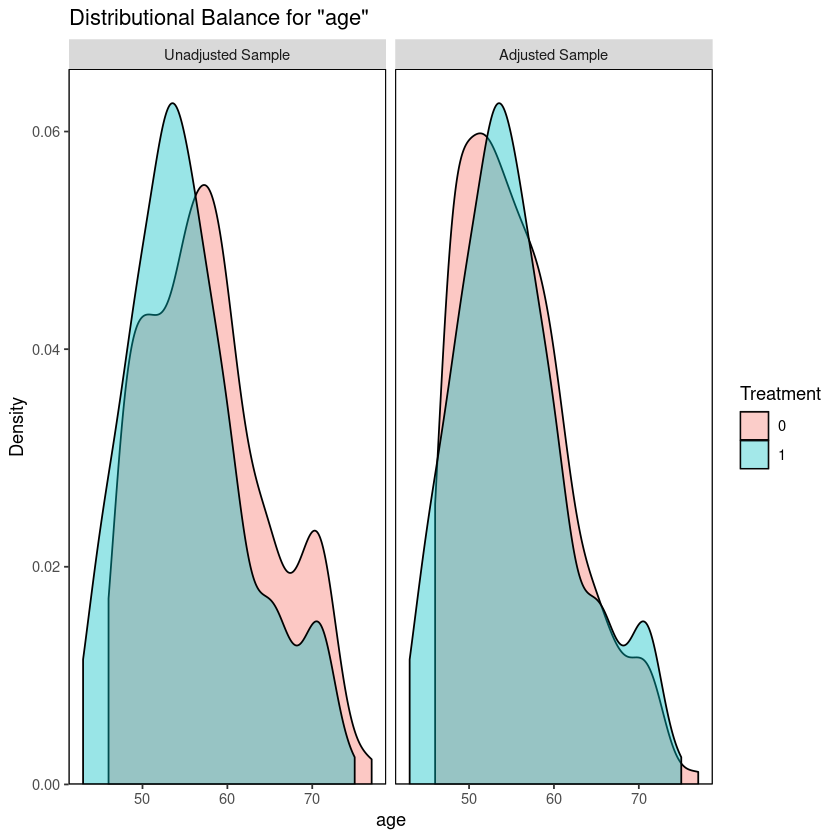

Saving 6.67 x 6.67 in image



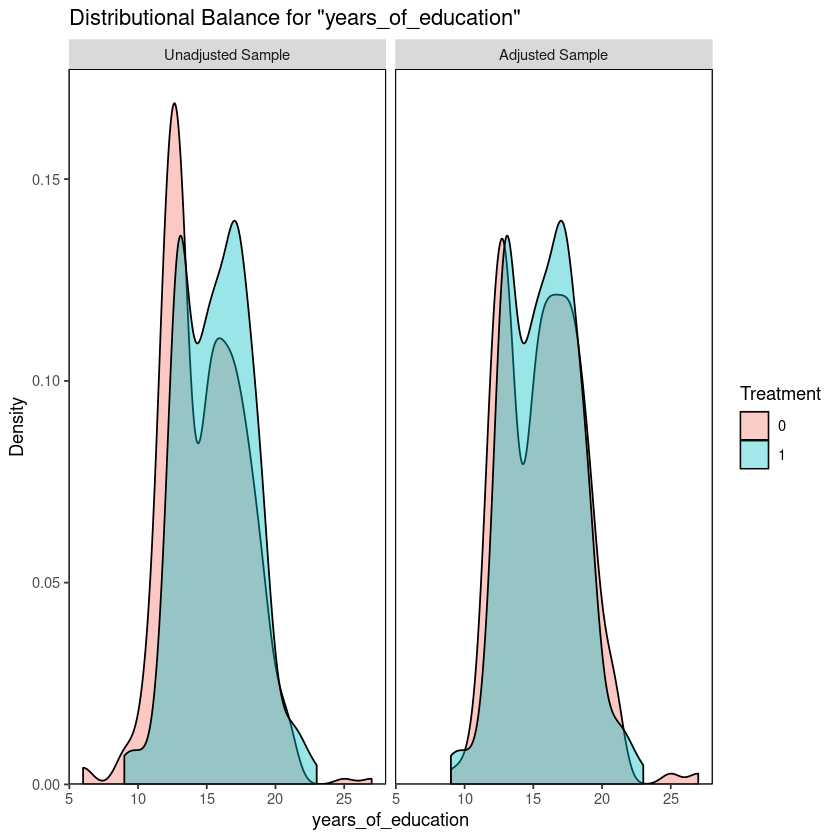

In [33]:
# Create barplot for balance assessment
bal.plot(mod_matchit, var.name="as.factor(sex)", which="both")
ggsave("../output/matching/bar_sex_matching.png")
bal.plot(mod_matchit, var.name="age", which="both")
ggsave("../output/matching/bar_age_matching.png")
bal.plot(mod_matchit, var.name="years_of_education", which="both")
ggsave("../output/matching/bar_yoe_matching.png")

In [34]:
# extract matched dataframe and write to csv
data_matched <- match.data(mod_matchit)
write.csv(data_matched, "../output/matching/postcovid_matched_cohort.csv")
data_unmatched <- match.data(unmatched)
dim(data_matched)

[1] 446  16

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



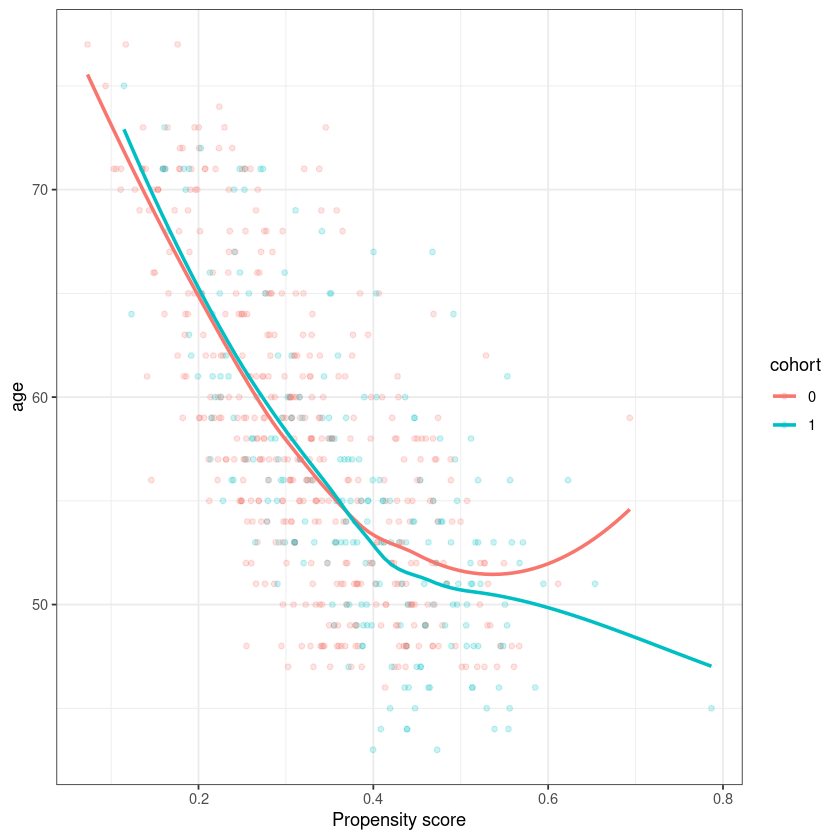

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'



ERROR: Error in `[.data.frame`(dta, , variable): undefined columns selected


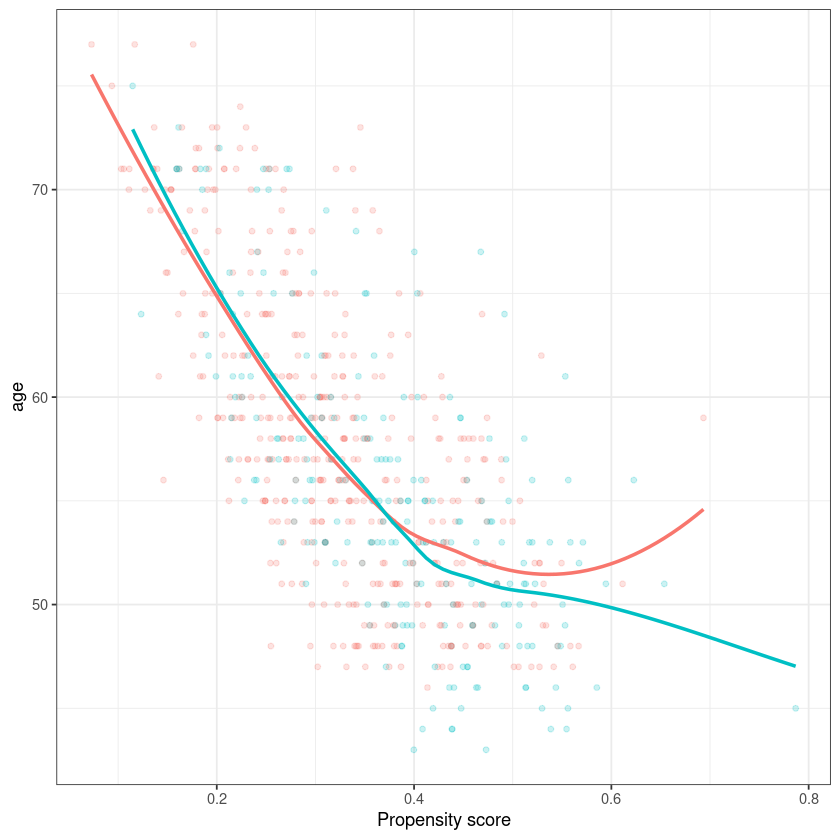

In [36]:
# Produce balance assessment figures
fn_bal <- function(dta, variable) {
  dta$variable <- dta[, variable]
  dta$cohort <- as.factor(dta$cohort)
  support <- c(min(dta$variable), max(dta$variable))
  ggplot(dta, aes(x = distance, y = variable, color = cohort)) +
    geom_point(alpha = 0.2, size = 1.3) +
    geom_smooth(method = "loess", se = F) +
    xlab("Propensity score") +
    ylab(variable) +
    theme_bw() +
    ylim(support)

}

fn_bal(data_unmatched, "age")
ggsave("../output/matching/propensity_scores_age_before_matching.png")

fn_bal(data_unmatched, "age") + theme(legend.position = "none")
ggsave("../output/matching/propensity_scores_sex_before_matching.png")

fn_bal(data_unmatched, "Education")
ggsave("../output/matching/propensity_scores_yoe_before_matching.png")

fn_bal(data_matched, "age")
ggsave("../output/matching/propensity_scores_age_after_matching.png")

fn_bal(data_matched, "age") + theme(legend.position = "none")
ggsave("../output/matching/propensity_scores_sex_after_matching.png")

fn_bal(data_matched, "Education")
ggsave("../output/matching/propensity_scores_yoe_after_matching.png")

In [15]:
# Statistical group comparison before matching
with(data_matched, t.test(age ~ cohort))
chisq.test(table(data_matched$sex, data_matched$cohort))
chisq.test(table(data_matched$hypertension, data_matched$cohort))
chisq.test(table(data_matched$hyperlipidemia, data_matched$cohort))
chisq.test(table(data_matched$diabetes, data_matched$cohort))
chisq.test(table(data_matched$smoking_ever, data_matched$cohort))


	Welch Two Sample t-test

data:  age by cohort
t = 0.30445, df = 441.91, p-value = 0.7609
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -1.076390  1.471009
sample estimates:
mean in group 0 mean in group 1 
       55.73543        55.53812 



	Pearson's Chi-squared test with Yates' continuity correction

data:  table(data_matched$sex, data_matched$cohort)
X-squared = 0.32882, df = 1, p-value = 0.5664



	Pearson's Chi-squared test with Yates' continuity correction

data:  table(data_matched$hypertension, data_matched$cohort)
X-squared = 0.73895, df = 1, p-value = 0.39



	Pearson's Chi-squared test with Yates' continuity correction

data:  table(data_matched$hyperlipidemia, data_matched$cohort)
X-squared = 0.049825, df = 1, p-value = 0.8234



	Pearson's Chi-squared test with Yates' continuity correction

data:  table(data_matched$diabetes, data_matched$cohort)
X-squared = 0.14752, df = 1, p-value = 0.7009



	Pearson's Chi-squared test with Yates' continuity correction

data:  table(data_matched$smoking_ever, data_matched$cohort)
X-squared = 0.0089905, df = 1, p-value = 0.9245
